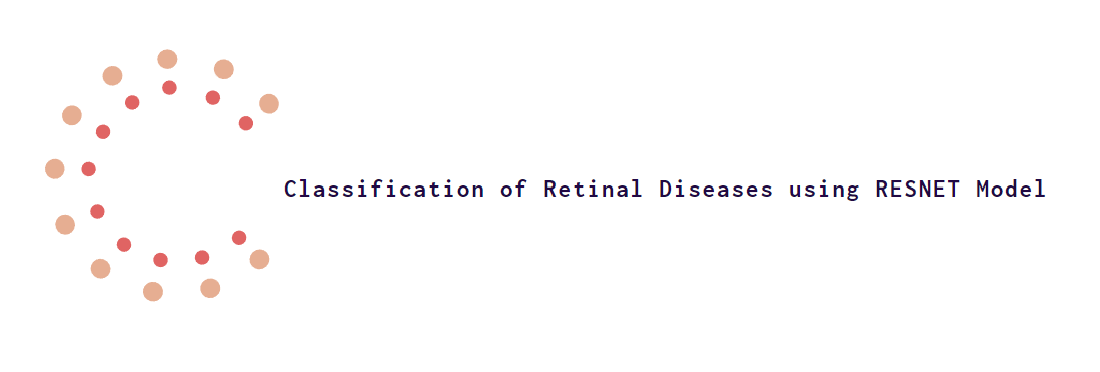

In [1]:
from skimage import io, transform

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

In [4]:
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
from tqdm import tqdm_notebook

import os
# base_dir = "C:\\Users\\Harilal\\Desktop\\retinopathy\\sampleimages" 
base_dir = r'C:\Resnet model\sampleimages'

<a href="https://colab.research.google.com/github/souravs17031999/Retinal_blindness_detection_Pytorch/blob/master/Single_test_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = r"C:\Resnet model\sampleimages", transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = Image.open(img_path)
        image.load()# if getting error, use PIL to load the image here.
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [6]:
# test_csv = pd.read_csv('C:\\Users\\Harilal\\Desktop\\retinopathy\\test.csv')
test_csv = pd.read_csv(r'C:\Resnet model\test.csv')


In [7]:
# test_path = "C:\\Users\\Harilal\\Desktop\\retinopathy\\test_images"
test_path = r'C:\Resnet model\test_image'

In [8]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
#     Perform the preprocessing on each image of the data set. By using the
#     compose function present in the transforms module we resize and
#     normalize the images.
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [9]:
test_csv['diagnosis'] = -1


In [10]:
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [12]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

In [13]:
def load_model(path):
  checkpoint = torch.load(path,map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=False) 

num_ftrs = model.fc.in_features 
out_ftrs = 5 
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001) 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

C:\Users\user\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    for param in child.parameters():
      param.requires_grad = True
  else:
    for param in child.parameters():
      param.requires_grad = False

In [16]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
model = load_model(r"C:\Resnet model\classifier\classifier.pt")

In [18]:
# test_dir = "C:\\Users\\Harilal\\Desktop\\retinopathy\\test_images"
test_dir = r'C:\Resnet model\test_image'

In [ ]:
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0
    for inputs, labels in test_loader:
        i += 1
        if i % 10 == 0:
            print(f'{i} pass step')
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        p_labels.append(preds)
    # getting ids of file images    

10 pass step
20 pass step


In [ ]:
pred_labels = []
for l in p_labels:
    for l1 in l:
        pred_labels.append(l1.item())

In [ ]:
def test_with_single_image(model, file, transform, classes):

    file = Image.open(file).convert('RGB')

    img = transform(file).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()

In [ ]:
import random

# test_dir = "C:\\Users\\Harilal\\Desktop\\retinopathy\\sampleimages"
# take random folder first
# save label
test_dir = r'C:\Resnet model\sampleimages'

# now take random file
files = os.listdir(test_dir)
print(files)
nums = random.randint(0, len(files)-1)
for i in range(0,len(files)-1):
    name = test_dir + "\\" + files[i]
    classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
    test_with_single_image = (model, name, test_transforms, classes)

print('Path: ', name)

In [ ]:
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
test_with_single_image = (model, name, test_transforms, classes)

In [ ]:
#gui.py
# Importing all packages
import tkinter as tk
from tkinter import *
from tkinter.ttk import *
from tkinter import messagebox
from PIL import Image,ImageTk
import os
from tkinter.filedialog import askopenfilename, asksaveasfilename
from model import *
#from send_sms import *
print('GUI SYSTEM STARTED...')
def OpenFile():
    if y:
        try:
            a = askopenfilename()
            print(a)
            value, classes = main(a)
            messagebox.showinfo("your report", ("Predicted Label: ", value, "\n Predicted Class: ", classes))
            image = Image.open(a)
            file = image.convert('RGB')
            plt.imshow(np.array(file))
            plt.title(f'Your Report \n Label : {value} \n Class : {classes}')
            plt.show()
            print('Thanks for using the system !')
        except Exception as error:
            print("File not selected ! Exiting..., Please try again")

y = True
root = Tk()
root.geometry('700x400')
root.title("DIABETIC RETINOPATHY CLASSIFICATION")
root.configure(bg='#c488fc')
label1 = tk.Label(root, text="DIABETIC RETINOPATHY",bg='white', font=('Arial', 30), justify="center")
label1.grid(padx=100, pady=30, row=0,sticky='W')
label2 = Label(root, text="Choose an image", font=('Arial', 15))
label2.grid(padx=230, pady=10, row=2, sticky='W')
button2 = tk.Button(root, text="Upload Image",bg='#cbc9be', command=OpenFile)
button2.grid(padx=400, pady=10, row=2)

root.mainloop()